In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras import mixed_precision

import plotly.graph_objects as go
from datetime import datetime, timedelta

# --- GPU-Konfiguration ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ GPU aktiviert: {gpus}")
else:
    print("⚠️ Keine GPU gefunden, CPU wird verwendet.")

# GPU-Optimierungen aktivieren
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("✅ Memory Growth aktiviert")

mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision aktiviert")

tf.config.optimizer.set_jit(True)
print("✅ XLA aktiviert")

# Benchmark-Test
print("\n🚀 Starte GPU-Benchmark...")
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    start = time.time()
    c = tf.matmul(a, b)
    # Synchronisation erfolgt automatisch, wenn wir das Ergebnis auswerten
    _ = c.numpy()  # zwingt TensorFlow, die Berechnung abzuschließen
    print("✅ Dauer für 10k x 10k Matrix-Multiplikation:", round(time.time() - start, 2), "Sekunden")

# --- Parameter ---
folderPath_His =  "/mnt/Trainingdata/ml_data/yh_his/D1/"
train_stocks = ["#PLTR", "#TSLA", "#PYPL", "#AAPL", "#AMZN","#NVDA"]  # Trainingsaktien

sequence_length = 30
forecast_horizon = 30

# --- Hilfsfunktion zum Laden und Vorbereiten der Daten ---
def load_and_prepare_data(stock):
    file_path = os.path.join(folderPath_His, f"{stock}.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Datei nicht gefunden: {file_path}")
    df = pd.read_csv(file_path)
    if "close" not in df.columns:
        raise ValueError(f"❌ Spalte 'close' fehlt in {file_path}")
    df = df.dropna(subset=["close"])
    normalized = (df["close"] - df["close"].mean()) / df["close"].std()
    X, y = [], []
    for i in range(len(normalized) - sequence_length - forecast_horizon):
        X.append(normalized.values[i:i+sequence_length])
        y.append(normalized.values[i+sequence_length:i+sequence_length+forecast_horizon])
    return np.array(X).reshape(-1, sequence_length, 1), np.array(y), df

# --- Trainingsdaten kombinieren ---
X_train_all, y_train_all = [], []
for stock in train_stocks:
    X_stock, y_stock, _ = load_and_prepare_data(stock)
    X_train_all.append(X_stock)
    y_train_all.append(y_stock)

X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

print(f"✅ Trainingsdaten: {X_train.shape}, Labels: {y_train.shape}")

# --- Modell definieren ---
input_layer = Input(shape=(sequence_length, 1))
lstm_out = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(input_layer)
output_layer = Dense(forecast_horizon)(lstm_out)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# --- Training ---
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, callbacks=[early_stop]) #ORG epochs=50

# --- Modell speichern ---

from keras.saving import save_model
model_name = "generic_multi_stock_lstm1.keras"
save_model(model, model_name)


#model.save("generic_multi_stock_lstm.h5")
#print("✅ Modell gespeichert: generic_multi_stock_lstm.h5")



✅ GPU aktiviert: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Memory Growth aktiviert
✅ Mixed Precision aktiviert
✅ XLA aktiviert

🚀 Starte GPU-Benchmark...
✅ Dauer für 10k x 10k Matrix-Multiplikation: 0.72 Sekunden
✅ Trainingsdaten: (32634, 30, 1), Labels: (32634, 30)
Epoch 1/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - loss: 0.0995
Epoch 2/50
509/510 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0429

2025-11-13 12:17:05.524359: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-13 12:17:06.149841: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 256 bytes spill stores, 256 bytes spill loads



510/510 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - loss: 0.0405
Epoch 3/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - loss: 0.0328
Epoch 4/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - loss: 0.0288
Epoch 5/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 75s 148ms/step - loss: 0.0272
Epoch 6/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 75s 147ms/step - loss: 0.0246
Epoch 7/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - loss: 0.0243
Epoch 8/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 146ms/step - loss: 0.0230
Epoch 9/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - loss: 0.0230
Epoch 10/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 75s 148ms/step - loss: 0.0228
Epoch 11/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - loss: 0.0221
Epoch 12/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 144ms/step - loss: 0.0217
Epoch 13/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 75s 146ms/step - loss: 0.0209
Epoch 14/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 75s 147ms/step - loss: 0.0203
Epoch 15/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 74s 146ms/step - loss: 0.0193
Epoch 16/50
510/510 ━━━━━

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,992 (441.39 KB)

 Trainable params: 37,662 (147.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 75,330 (294.27 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


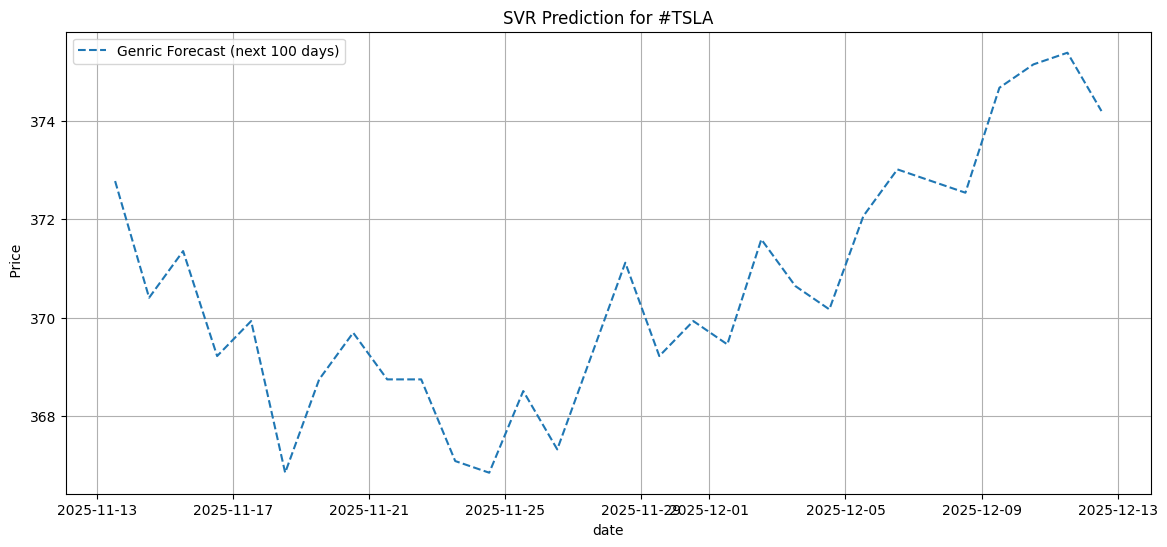

In [ ]:

predict_stock = "#TSLA"  # Neue Aktie für Vorhersage
from keras.models import load_model

# Modell laden
model1 = load_model(model_name)

# Überprüfen
model1.summary()

# --- Vorhersage für MSFT ---
X_msft, _, df_msft = load_and_prepare_data(predict_stock)
last_sequence = X_msft[-1].reshape(1, sequence_length, 1)
pred = model1.predict(last_sequence)[0]
pred_denorm = pred * df_msft["close"].std() + df_msft["close"].mean()

# --- Plot ---
future_dates = [datetime.today() + timedelta(days=i) for i in range(forecast_horizon)]



import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

plt.plot(future_dates, pred_denorm, label="Genric Forecast (next 100 days)", linestyle='--')
plt.xlabel("date")
plt.ylabel(   " Price")
plt.title("SVR Prediction for "+ predict_stock)
plt.legend()
plt.grid(True)
plt.show()
